In [4]:
import numpy as np
import sympy as sp
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Load the data 
class_1_data = np.load('class1.npy') # label 0 
class_2_data = np.load('class2.npy') # label 1 

#Built a numpy array 
X = np.concatenate((class_1_data,class_2_data))

# True label array 
T = []
for n in range(0, len(X)):
    if (n < len(class_1_data)):
        T.append(0)
    else:
        T.append(1)

In [6]:
def print_matrix (W1,b1,W2,b2):
    # Convert to sympy matric for proper display the matric of the generated weights and bias terms 
    W1_mat = sp.Matrix(W1)
    b1_mat = sp.Matrix(b1)
    W2_mat = sp.Matrix(W2)
    b2_mat = sp.Matrix(b2)
    
    y_prob = forward(X,W1,W2,b1,b2)
    print("W^(1) =")
    sp.pprint(W1_mat, use_unicode = True)
    print("\nb^(1) =")
    sp.pprint(b1_mat, use_unicode=True)
    print("\nW^(2) =")
    sp.pprint(W2_mat, use_unicode=True)
    print("\nb^(2) =")
    sp.pprint(b2_mat, use_unicode=True)

def print_mlp_expressions(W1, b1, W2, b2, feature_names=None, decimals=3, act_symbol='σ'):
    """
    Pretty-prints math-style expressions for a 2-layer MLP:
        input (D) -> hidden (H) -> output (O)
    using sigmoid notation 'σ' by default.

    Args
    ----
    W1 : (D, H) array  input->hidden weights
    b1 : (H,)   array  hidden biases
    W2 : (H, O) array  hidden->output weights
    b2 : (O,)   array  output biases
    feature_names : list[str] of length D (optional). Default: x1, x2, ...
    decimals : int  number of decimals in coefficients
    act_symbol : str activation symbol to print (e.g., 'σ' or 'sigmoid')

    Returns
    -------
    dict with lists of strings for z1, h, z2, yhat (also printed).
    """
    W1 = np.asarray(W1); b1 = np.asarray(b1)
    W2 = np.asarray(W2); b2 = np.asarray(b2)

    D, H = W1.shape
    assert b1.shape == (H,), "b1 must be shape (H,)"
    H2, O = W2.shape
    assert H2 == H, "W2 must have same hidden size as W1 second dim"
    assert b2.shape == (O,), "b2 must be shape (O,)"

    # Feature names
    if feature_names is None:
        feature_names = [f"x{i+1}" for i in range(D)]

    def coef(x):  # format with sign and rounding
        return f"{x:+.{decimals}f}"

    lines_z1, lines_h = [], []
    print("\nHidden layer pre-activations z^(1):")
    z1_vec_parts = []
    for j in range(H):
        terms = [f"{coef(W1[i, j])}*{feature_names[i]}" for i in range(D)]
        expr = " + ".join(terms) + f" {coef(b1[j])}"
        lines_z1.append(f"z1_{j+1} = {expr}")
        z1_vec_parts.append(expr)
        print(" ", lines_z1[-1])
    print("\nHidden activations h = σ(z^(1)):")
    for j in range(H):
        lines_h.append(f"h{j+1} = {act_symbol}(z1_{j+1})")
        print(" ", lines_h[-1])

    print("\nOutput layer pre-activations z^(2):")
    lines_z2, lines_y = [], []
    for k in range(O):
        terms = [f"{coef(W2[j, k])}*h{j+1}" for j in range(H)]
        expr = " + ".join(terms) + f" {coef(b2[k])}"
        lines_z2.append(f"z2_{k+1} = {expr}")
        print(" ", lines_z2[-1])
    print("\nFinal outputs ŷ = σ(z^(2)):")
    for k in range(O):
        lines_y.append(f"ŷ{k+1} = {act_symbol}(z2_{k+1})")
        print(" ", lines_y[-1])

    return {"z1": lines_z1, "h": lines_h, "z2": lines_z2, "yhat": lines_y}


In [7]:
# Function to plot the original data 
def plot_data_with_labels(X, y):

    plt.figure(figsize=(7,6))
    plt.grid(True, alpha=0.3)

    # scatter by true label
    plt.scatter(X[:,0], X[:,1], c=y, cmap="bwr", edgecolor="k", s=45)

    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Ground Truth Data")
    plt.show()

In [181]:
# Q2 

### Condition ###############################
# Multi-Layer Perceptron (MLP) 2-3-1 
# Using sigmoid as activation function
# W1*X + b1 @ using normal distribution to randomly generate [mean = 0 , sigma = 0.1]
mu = 0 # mean for using normal distribution 
sigma = 0.1 # std deviation for using normal distribution 
threshold = 0.5 # threshold for discriminat class 1 or 2 

# Random weight ( 9 connections ) 

# Function to generate weight 
def generate_weight(x,cov,size_weight):
    rng = np.random.default_rng() # Declare a random object 
    W = rng.normal(x,cov,size=size_weight) # Weight term 
    B = rng.normal(x,cov,size=(size_weight[1],)) # Bias term 
    return W,B
    
# Activation function 
def sigmoid(z): 
    return 1/(1+np.exp(-z))

# Sigmoid derivative function 
def sigmoid_deriv(x):
    s = sigmoid(x)
    return s*(1-s)
    
# Feed forward function (One layer inputs + one hidden layer + one output layer)
def forward(X,W1,W2,b1,b2):
    z1 = X @ W1 + b1  # Input to hidden layer 
    h1 = sigmoid(z1) 
    z2 = h1 @ W2 + b2
    y = sigmoid(z2).ravel()
    return y,z1,h1,z2 

# Backpropagation function 
def backpropagation(X,T, W1, b1, W2, b2, eta=0.1, epochs=1):
    N = X.shape[0] # get the dimension of the input data
    T = np.array(T).reshape(-1,1)
    error_array = []

    for epoch in range(epochs):
        # pass the forward function 
        y, z1, h1, z2 = forward(X,W1,W2,b1,b2)
        y_predict = (y > threshold).astype(int)
        y_predict = y_predict.reshape(-1,1)

        # LSE 
        loss = np.mean(y_predict-T)**2
        error_array.append(loss)
        
        # loss function (Using Squared error)
        error = (y_predict - T)
    
        # Perform backward propagation 
        delta2 = error*sigmoid_deriv(z2)
        dW2 = h1.T @ delta2 / N # matrix multiplication 
        db2 = delta2.mean(axis=0)

        delta1 = (delta2 @ W2.T) * sigmoid_deriv(z1)
        dW1 = X.T @ delta1 / N
        db1 = delta1.mean(axis=0)
        # update 
        W2 = W2 - eta * dW2
        b2 = b2 - eta * db2
        W1 = W1 - eta * dW1
        b1 = b1 - eta * db1
    return W1, W2, b1, b2, error_array       


# Function to plot the decision boundary with using contour  
def plot_decision_boundary(X,W1, W2, b1, b2):
    plt.figure(figsize=(7,6))
    plt.grid(True, alpha=0.3)

    # Build mesh grid
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Forward pass on grid (reuse forward function)
    zz = forward(grid, W1, W2, b1, b2)[0].reshape(xx.shape)
    
    # Plot the decision boundary
    Z =  (zz > threshold).astype(int)
    # Plot decision regions with blue (class_0) and yellow (class_1)
    cmap_contour = mcolors.ListedColormap(["#add8e6", "yellow"])
    # Plot the contour
    plt.contourf(xx,yy,Z,cmap=cmap_contour)

    # Plot the orignal data points with green (class_0) and red (class_1)
    cmap_original = mcolors.ListedColormap(["green", "red"])
    plt.scatter(X[:, 0], X[:, 1], c=T, cmap=cmap_original)

    # legend settings
    legend_handles = [
        mpatches.Patch(color="#add8e6", label="Predicted region class 0"),
        mpatches.Patch(color="yellow",   label="Predicted region class 1"),
        mpatches.Patch(color="green", label="Class 0"),
        mpatches.Patch(color="red",   label="Class 1"),
    ]
    
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title("Decision Boundary")
    plt.legend(handles=legend_handles, loc="best")
    plt.show()

def plot_ROC_function(T,y_pred1):
    fpr, tpr, thr = roc_curve(T, y_pred1)
    print(tpr)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
    plt.plot([0,1],[0,1],'--', linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(alpha=0.3)

def plot_loss_function(loss_array):
    plt.figure()
    plt.plot(loss_array)
    plt.xlabel("Epoch")
    plt.ylabel("MSE_Loss")
    plt.title("Training Loss")
    plt.show()

In [182]:
# Obtain the weight and bias term from random generator (normal distribution) 
#W1,b1 = generate_weight(mu,sigma,(2,3)) # first layer is 2x3 
#W2,b2 = generate_weight(mu,sigma,(3,1)) # second layer is 3x1 
#print(b1)


Hidden layer pre-activations z^(1):
  z1_1 = -0.101*x1 + -0.207*x2 +0.021
  z1_2 = -0.087*x1 + +0.001*x2 +0.016
  z1_3 = -0.034*x1 + -0.024*x2 +0.001

Hidden activations h = σ(z^(1)):
  h1 = σ(z1_1)
  h2 = σ(z1_2)
  h3 = σ(z1_3)

Output layer pre-activations z^(2):
  z2_1 = -0.139*h1 + -0.062*h2 + +0.031*h3 +0.081

Final outputs ŷ = σ(z^(2)):
  ŷ1 = σ(z2_1)


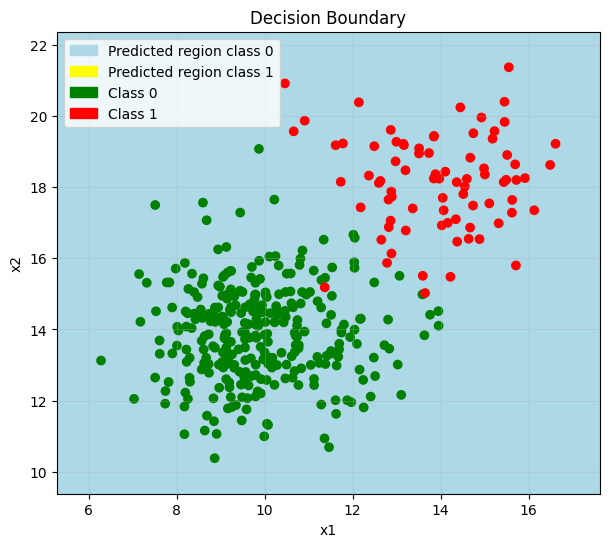

[0. 1.]
Accuracy : 0.21052631578947367
Precision: 0.21052631578947367
Recall   : 1.0


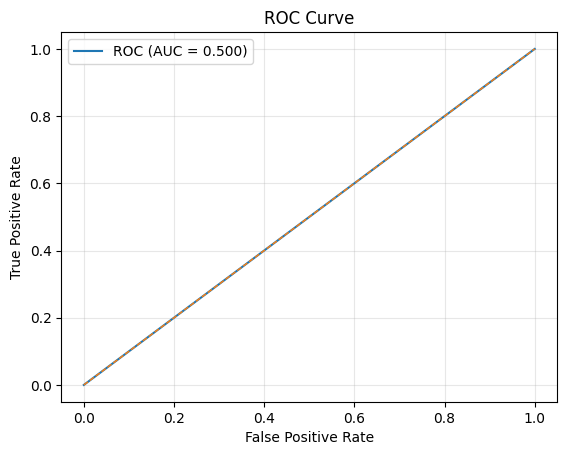

In [187]:
#print_matrix(W1,b1,W2,b2)
# Before Back_Propagation 
print_mlp_expressions(W1, b1, W2, b2, feature_names=["x1","x2"])
y_prob,z1,h1,z2  = forward(X,W1,W2,b1,b2)
y_pred = (y_prob > threshold).astype(int)
plot_decision_boundary(X, W1, W2,b1, b2)
plot_ROC_function(T,y_pred)
print("Accuracy :", accuracy_score(T, y_pred)) # Calculate accuracy score
print("Precision:", precision_score(T, y_pred, zero_division=0)) # Calculate precison 
print("Recall   :", recall_score(T, y_pred, zero_division=0)) # Calculate Recall

########

Hidden layer pre-activations z^(1):
  z1_1 = -0.099*x1 + -0.205*x2 +0.021
  z1_2 = -0.079*x1 + +0.013*x2 +0.016
  z1_3 = -0.037*x1 + -0.028*x2 +0.000

Hidden activations h = σ(z^(1)):
  h1 = σ(z1_1)
  h2 = σ(z1_2)
  h3 = σ(z1_3)

Output layer pre-activations z^(2):
  z2_1 = -0.141*h1 + -0.080*h2 + +0.013*h3 +0.027

Final outputs ŷ = σ(z^(2)):
  ŷ1 = σ(z2_1)


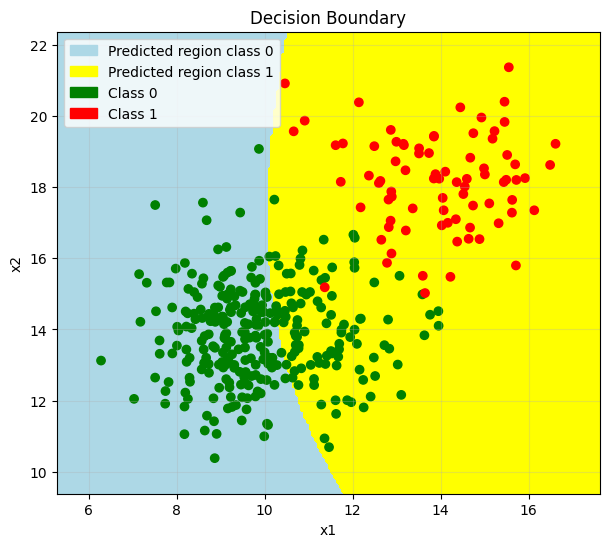

[0. 1. 1.]
Accuracy : 0.7394736842105263
Precision: 0.44692737430167595
Recall   : 1.0


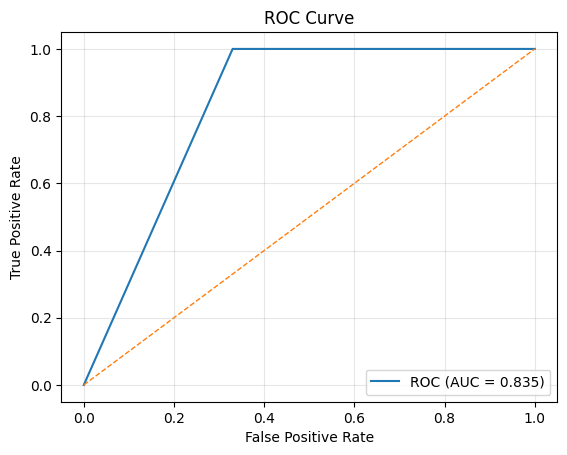

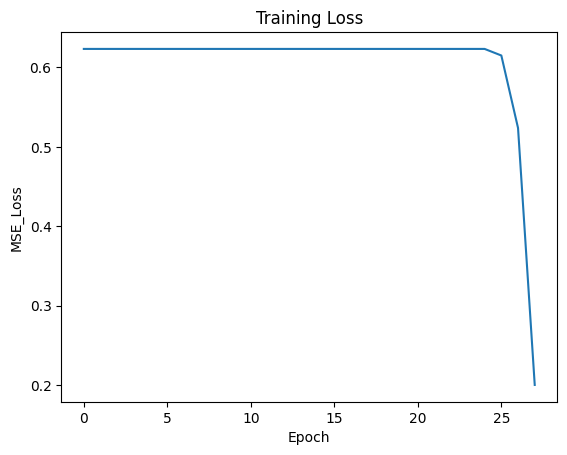

In [188]:
# Aftey_pred = (y_prob > threshold).astype(int)r Back_Propagation
W1_new,W2_new,b1_new,b2_new,error_array = backpropagation(X,T, W1, b1, W2, b2, eta=0.01, epochs=28)
print("########")
print_mlp_expressions(W1_new, b1_new, W2_new, b2_new, feature_names=["x1","x2"])
y_prob,z1,h1,z2  = forward(X,W1_new,W2_new,b1_new,b2_new)
y_pred = (y_prob > threshold).astype(int)
#print(y_prob)
#print(y_pred)
plot_decision_boundary(X, W1_new, W2_new,b1_new, b2_new)
plot_ROC_function(T,y_pred)
print("Accuracy :", accuracy_score(T, y_pred)) # Calculate accuracy score
print("Precision:", precision_score(T, y_pred, zero_division=0)) # Calculate precison 
print("Recall   :", recall_score(T, y_pred, zero_division=0)) # Calculate Recall
plot_loss_function(error_array)

In [129]:
print(error_array)

[0.31163434903047094, 0.31163434903047094, 0.0216101108033241, 0.009006232686980609]


In [145]:
np.argmin(error_array)

84